In [16]:
from pathlib import Path
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is ready")

cuda is ready


In [27]:
DATA_DIR = Path("/workspace/data")
IMG_DIR = Path("/workspace/data/images/image_train")
X_train = pd.read_csv(DATA_DIR/"X_train_update.csv", index_col=0)
Y_train = pd.read_csv(DATA_DIR/"Y_train_CVw08PX.csv", index_col=0)

df = X_train.join(Y_train, how="inner")

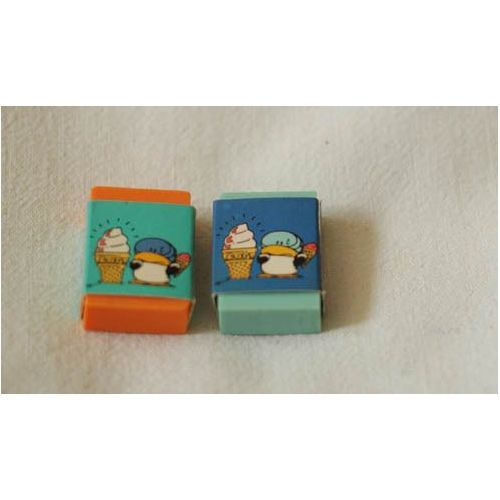

In [19]:
def get_img(index):
    row = df.iloc[index]
    image_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
    img = Image.open(IMG_DIR/image_name)
    img_display = display(img)
    return img_display

get_img(84915)

In [20]:
preprocess = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [21]:
def get_img_data_by_index(index):
    row = df.iloc[index]
    image_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
    img = Image.open(IMG_DIR / image_name).convert("RGB")
    img_tensor = preprocess(img)

    return img_tensor

tensor_data = get_img_data_by_index(5)
display(f"return image shape: {tensor_data.shape}")

'return image shape: torch.Size([3, 224, 224])'

'image en gray shape: torch.Size([3, 224, 224])'

'valeur en gouche haute coin:'

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

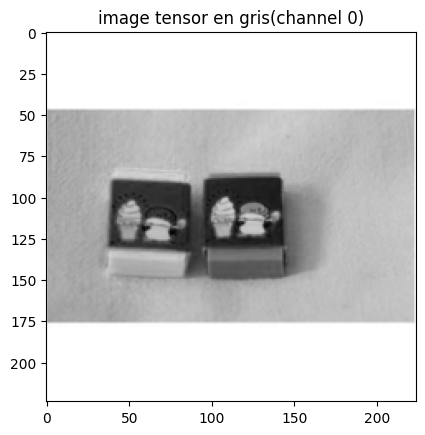

In [22]:
img_tensor = get_img_data_by_index(84915)

display(f"image en gray shape: {img_tensor.shape}")

display("valeur en gouche haute coin:")
display(img_tensor[0][0:6, 0:6])

plt.imshow(img_tensor[0], cmap="gray")
plt.title("image tensor en gris(channel 0)")
plt.show()

In [23]:
def manual_convolution(img_tensor):

    kernel_vertical = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]])

    kernel_horizontal = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]])

    # Get dimensions img_tensor, kernel_vertical
    channels, img_height, img_width = img_tensor.shape
    kernel_height, kernel_width = kernel_horizontal.shape

    # Calculate output dimensions for convolution
    output_height = img_height - kernel_height + 1
    output_width = img_width - kernel_width + 1

    # initialize output image
    output_img_vertical = np.zeros((output_height, output_width))
    output_img_horizontal = np.zeros((output_height, output_width))
    
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest
            region = img_tensor[0, i:i+kernel_height, j:j+kernel_width].numpy()
            # Perform element-wise multiplication and sum the result
            conv_value = np.sum(region * kernel_vertical)
            output_img_vertical[i, j] = conv_value

    for i in range(output_height):
        for j in range(output_width):
            region = img_tensor[0, i:i+kernel_height, j:j+kernel_width].numpy()
            conv_value = np.sum(region * kernel_horizontal)
            output_img_horizontal[i, j] = conv_value

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(output_img_vertical, cmap='gray')
    axes[0].set_title("Output Image after Vertical Edge Detection")
    axes[1].imshow(output_img_horizontal, cmap='gray')
    axes[1].set_title("Output Image after Horizontal Edge Detection")
    result = plt.show()
    
    return result

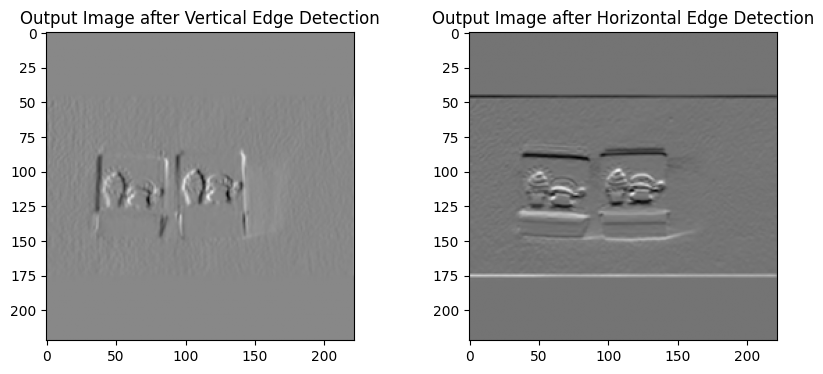

In [24]:
manual_convolution(img_tensor)

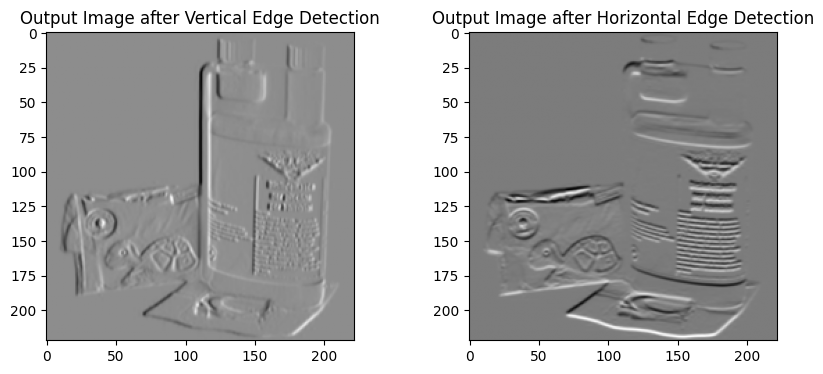

In [26]:
img_test = get_img_data_by_index(20)
manual_convolution(img_test)
